In [62]:
import json
import pandas as pd

from collections import deque
from matplotlib import pyplot as plt

In [18]:
graph = None

with open('../results/unweighted_graph.json', 'r') as f:
    graph = json.load(f)

# Graph Properties

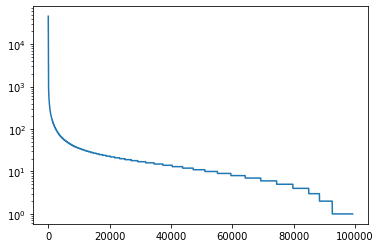

In [67]:
lens = [len(s) for s in graph.values()]

plt.yscale('log')
plt.plot(sorted(lens, reverse=True))

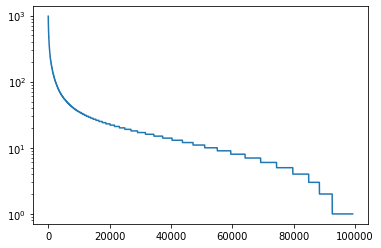

In [76]:
plt.yscale('log')
plt.plot(sorted(lens, reverse=True)[100:])

In [134]:
def remove_words(graph, to_remove):
    cleaned_graph = {}
    for k,v in graph.items():
        if k in to_remove:
            continue
        cleaned_graph[k] = set()
        for vv in v:
            if vv in to_remove:
                continue
            cleaned_graph[k].add(vv)
    return cleaned_graph

In [141]:
to_remove = set([k for k,v in graph.items() if len(v) > 1000])
print(len(to_remove))
cleaned_graph = remove_words(graph, to_remove)
print(len(cleaned_graph))

96
99183


In [146]:
proper_words = set([k for k in cleaned_graph.keys() if k[0].isupper()])
print(len(proper_words))
cleaner_graph = remove_words(cleaned_graph, proper_words)
print(len(cleaner_graph))

assert(all(not k[0].isupper() for k in cleaner_graph))

17079
82104


# Graph Search

In [21]:
def dfs(graph, curr, dst, visited, length):
    if curr == dst:
        return [[]]
    if curr in visited or length <= 0:
        return []
    
    to_ret = []
    for neighbor in graph[curr]:
        new_visited = visited | set([curr])
        if neighbor in visited:
            continue
        to_ret += [[neighbor] + a for a in dfs(graph, neighbor, dst, new_visited, length-1)]
    return to_ret

In [23]:
assert(len(dfs(graph, 'algebra', 'she', set(), 3)) == len(dfs(graph, 'she', 'algebra', set(), 3)))

In [31]:
def bfs(graph, src, dst, max_len):
    q = deque([src])
    visited = {src: (0, 1)}
    
    while q:
        curr = q.popleft()
        curr_len, count = visited[curr]
        
        if dst == curr:
            return (curr_len, count)
        
        if curr_len >= max_len:
            break
        
        for neighbor in graph[curr]:
            if neighbor not in visited:
                visited[neighbor] = (curr_len+1, count)
            elif visited[neighbor][0] == curr_len:
                visited[neighbor][1] += count
            else:
                continue
            
            q.append(neighbor)
            
    return (None, None)

# Pairwise Evaluation

In [15]:
with open('../results/weat.json') as fin:
    weat_words = json.load(fin)

math_male = set(weat_words['Math_Arts_Male_Female']['Male attributes'])
science_male = set(weat_words['Science_Arts_Male_Female']['Male attributes'])
male_words = math_male.union(science_male)

math_female = set(weat_words['Math_Arts_Male_Female']['Female attributes'])
science_female = set(weat_words['Science_Arts_Male_Female']['Female attributes'])
female_words = math_female.union(science_female) 

math_arts = set(weat_words['Math_Arts_Male_Female']['Arts Words'])
science_arts = set(weat_words['Science_Arts_Male_Female']['Arts words'])
arts_words = math_arts.union(science_arts)
science_words = set(weat_words['Science_Arts_Male_Female']['Science words'])
math_words = set(weat_words['Math_Arts_Male_Female']['Math words'])

female_words.remove('hers')
math_female.remove('hers')
science_female.remove('hers')

word_lists = {
    'male': male_words,
    'math': math_words,
    'science': science_words,
    'arts': arts_words,
    'female': female_words,
    'm1': math_male,
    'm2': science_male,
    'f1': math_female,
    'f2': science_female,
    'a1': math_arts,
    'a2': science_arts,
}
print(word_lists)

{'male': {'son', 'boy', 'brother', 'uncle', 'man', 'he', 'father', 'male', 'him', 'grandfather', 'his'}, 'math': {'computation', 'geometry', 'algebra', 'numbers', 'addition', 'equations', 'math', 'calculus'}, 'science': {'biology', 'physics', 'science', 'astronomy', 'chemistry', 'technology', 'experiment'}, 'arts': {'drama', 'dance', 'symphony', 'novel', 'art', 'literature', 'poetry', 'sculpture'}, 'female': {'girl', 'her', 'sister', 'daughter', 'mother', 'she', 'woman', 'grandmother', 'female', 'aunt'}, 'm1': {'son', 'boy', 'brother', 'man', 'he', 'male', 'him', 'his'}, 'm2': {'son', 'uncle', 'he', 'him', 'brother', 'father', 'grandfather', 'his'}, 'f1': {'girl', 'her', 'sister', 'daughter', 'she', 'woman', 'female'}, 'f2': {'her', 'daughter', 'sister', 'mother', 'aunt', 'she', 'grandmother'}, 'a1': {'drama', 'dance', 'symphony', 'novel', 'art', 'literature', 'poetry', 'sculpture'}, 'a2': {'drama', 'dance', 'symphony', 'novel', 'art', 'literature', 'poetry'}}


In [128]:
def pairwise_counts(graph, l1, l2):
    c = {}
    for w1 in word_lists[l1]:
        print(w1)
        c[w1] = {}
        for w2 in word_lists[l2]:
            c[w1][w2] = len(dfs(graph, w1, w2, set(), 3))
            
    return c

def pairwise_mult(graph, ls1, ls2):
    return {l1: {l2: pd.DataFrame.from_dict(pairwise_counts(graph, l1, l2)) for l2 in ls2} for l1 in ls1}

In [147]:
math_nums = pairwise_mult(cleaner_graph, ['math', 'a1'], ['m1', 'f1'])

computation
geometry
algebra
numbers
addition
equations
math
calculus
computation
geometry
algebra
numbers
addition
equations
math
calculus
drama
dance
symphony
novel
art
literature
poetry
sculpture
drama
dance
symphony
novel
art
literature
poetry
sculpture


In [148]:
science_nums = pairwise_mult(cleaner_graph, ['science', 'a2'], ['m2', 'f2'])

biology
physics
science
astronomy
chemistry
technology
experiment
biology
physics
science
astronomy
chemistry
technology
experiment
drama
dance
symphony
novel
art
literature
poetry
drama
dance
symphony
novel
art
literature
poetry


In [149]:
(math_nums['math']['f1'].sum() / math_nums['math']['m1'].sum()).mean()

0.4581083623690498

In [150]:
(math_nums['a1']['f1'].sum()/(math_nums['a1']['m1'].sum())).mean()

0.48580117406687806

In [151]:
(science_nums['science']['f2'].sum()/(science_nums['science']['m2'].sum())).mean()

0.5161796879190544

In [152]:
(science_nums['a2']['f2'].sum()/(science_nums['a2']['m2'].sum())).mean()

0.47454759188517254